In [76]:
import psycopg2
import geopandas as gpd
import json
from shapely.geometry import shape

In [77]:
conn = psycopg2.connect(database = "manila_osm",
                        host = "localhost",
                        user = "postgres",
                        password = "admin",
                        port = "5432")
# conn.autocommit = True
cursor = conn.cursor()
cursor.execute('SELECT osm_id, ST_AsGeoJson(wkb_geometry) FROM test2')

In [78]:
streets = []
for osm_id, feature in cursor:
    street = {}
    geometry = json.loads(feature)
    street["osm_id"] = int(osm_id)
    street["geometry"] = shape(geometry)
    streets.append(street)
streets = gpd.GeoDataFrame(streets, crs="EPSG:4326")
print(streets.head())

    osm_id                                           geometry
0      267  MULTILINESTRING ((121.05195 14.65011, 121.0520...
1  2667097  MULTILINESTRING ((120.99682 14.55577, 120.9967...
2  2667099  MULTILINESTRING ((120.98539 14.60460, 120.9854...
3  2667105  MULTILINESTRING ((120.99380 14.54125, 120.9949...
4  2667111  MULTILINESTRING ((120.98018 14.59292, 120.9801...


    AQI                                           geometry
0  73.0  POLYGON ((121.01455 14.67032, 121.01455 14.666...
1  75.0  POLYGON ((121.02338 14.67032, 121.02338 14.668...
2  72.0  POLYGON ((121.01278 14.67032, 121.01455 14.670...
3  75.0  POLYGON ((121.01985 14.66856, 121.01985 14.666...
4  73.0  POLYGON ((121.01278 14.66680, 121.01278 14.665...


<Axes: >

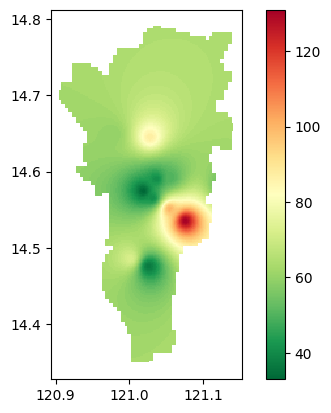

In [79]:
date_time = "29-12-2023_19-35-57"
aqi_polygons = gpd.read_file("./temp/polygonized_"+date_time+".json")
print(aqi_polygons.head())
aqi_polygons.plot(column="AQI", cmap="RdYlGn_r", legend=True)

       osm_id                                           geometry   AQI
0         267  MULTILINESTRING ((121.05195 14.65011, 121.0520...  72.0
453   4588984  MULTILINESTRING ((121.05404 14.65414, 121.0550...  72.0
813   4928675  MULTILINESTRING ((121.03973 14.67688, 121.0396...  72.0
1160  4960401  MULTILINESTRING ((121.05230 14.64716, 121.0525...  72.0
1165  4960406  MULTILINESTRING ((121.05353 14.65165, 121.0536...  72.0


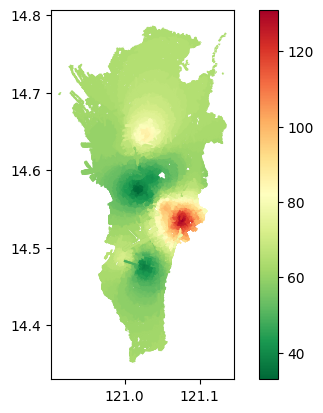

In [80]:
streets_aqi = streets.sjoin(aqi_polygons, how="inner", predicate="intersects")
print(streets_aqi[["osm_id","geometry","AQI"]].head())
streets_aqi.plot(column="AQI", cmap="RdYlGn_r", legend=True)
streets_aqi.to_file("./temp/test_polygons.json", driver="GeoJSON")

In [81]:
# for osm_id in streets.osm_id:
#     cursor.execute(f"INSERT INTO street_aqi (osm_id) VALUES ({osm_id})")
# conn.commit()

In [82]:
# aqi_dt = "aqi_"+date_time.replace("-", "_")
# cursor.execute(f"ALTER TABLE street_aqi ADD COLUMN IF NOT EXISTS {aqi_dt} DOUBLE PRECISION")
# for osm_id in streets.osm_id:
#     avg_aqi = streets_aqi.loc[(streets_aqi["osm_id"] == osm_id), "AQI"].mean()
#     cursor.execute(f"UPDATE street_aqi SET {aqi_dt} = {avg_aqi} WHERE osm_id = {osm_id}")
# conn.commit()

In [83]:
date_time = "2023-12-29 19:35:57"
cursor.execute(f"INSERT INTO data_timestamps (data_timestamp) VALUES ('{date_time}') ON CONFLICT DO NOTHING")
for street in streets_aqi.itertuples():
    cursor.execute(f"INSERT INTO street_aqi (osm_id, wkb_geometry, aqi, data_timestamp) VALUES ({street.osm_id}, ST_AsBinary('{street.geometry}'::geometry), {street.AQI}, '{date_time}')")
conn.commit()